### Dependencies & Constants

In [33]:
#Importing all dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import os
import shutil
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
 

In [3]:
PROJECT_DIR = '.'
DATA_ZIP = '../input/dogs-vs-cats/train.zip'
DATA_DIR = f'{PROJECT_DIR}/train'
BATCH_SIZE = 40
SEED = 30

### Data preprocessing

In [4]:
if not os.path.isdir(DATA_DIR): os.mkdir(DATA_DIR)

assert os.path.isfile(DATA_ZIP), f"Couldn't find the dataset {DATA_ZIP} at {PROJECT_DIR}"

if not any(os.scandir(DATA_DIR)):
    with zipfile.ZipFile(DATA_ZIP, 'r') as data_ref:
        data_ref.extractall(PROJECT_DIR)
else:
     print("Data directory is not empty, nothing changes!")

In [5]:
images = pd.DataFrame([f for f in os.listdir(DATA_DIR) if 'jpg' in f], columns =['names'])
print(len(images))

25000


### Spliting the data to trian, test, dev (validation) in the structure below

```
.
└── train
    ├── dev
    │   ├── cats
    │   └── dogs
    ├── test
    │   ├── cats
    │   └── dogs
    └── train
        ├── cats
        └── dogs
```

In [6]:
splits = {"train":[], "dev":[], "test":[]}
splits["train"], splits["dev"], splits["test"] = \
    np.split(images.sample(frac=1, random_state=SEED), [int(.6*len(images)), int(.8*len(images))])

for data_split in splits.keys():

    split_dir = f'{DATA_DIR}/{data_split}' 
    cats_dir, dogs_dir = f'{split_dir}/cats', f'{split_dir}/dogs'

    splits_folders = [split_dir, cats_dir, dogs_dir]

    for dir in splits_folders:
        if not os.path.isdir(dir): 
            os.mkdir(dir)
            print(f'{dir} has been created')

    if(any(os.scandir(cats_dir))):
        print("Data directory is not empty")
        continue

    for f in splits[data_split].names :
        if 'cat' in f: shutil.move(os.path.join(DATA_DIR, f), os.path.join(cats_dir, f))
        
    for f in splits[data_split].names :
        if 'dog' in f: shutil.move(os.path.join(DATA_DIR, f), os.path.join(dogs_dir, f))

./train/train has been created
./train/train/cats has been created
./train/train/dogs has been created
./train/dev has been created
./train/dev/cats has been created
./train/dev/dogs has been created
./train/test has been created
./train/test/cats has been created
./train/test/dogs has been created


### Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function = preprocess_input
)

dev_test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)


### Loading the images in batches

In [8]:
train_dataset = train_datagen.flow_from_directory(
    f'{DATA_DIR}/train',
    color_mode="rgb",
    target_size=(299, 299),
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    interpolation='nearest'
)

dev_dataset = dev_test_datagen.flow_from_directory(
    f'{DATA_DIR}/dev',
    color_mode="rgb",
    target_size=(299, 299),
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    interpolation='nearest'
)

test_dataset = dev_test_datagen.flow_from_directory(
    f'{DATA_DIR}/test',
    color_mode="rgb",
    target_size=(299, 299),
    shuffle=False,
    seed=SEED,
    batch_size=1,
    class_mode='binary',
    interpolation='nearest'
)

Found 15000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


### Building the model

In [9]:
def prepare_model():

    base_model = keras.applications.InceptionResNetV2(
        include_top=False,
        input_shape=(299, 299, 3),
        weights="imagenet",
    )
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(256, activation = 'relu'),
        Dropout(0.2),
        Dense(2, activation = 'softmax')
    ])

    base_model.trainable = False
    model.summary()
    
    return model

In [ ]:
model = prepare_model()

In [10]:
!conda install -y gdown 
import gdown 
url = 'https://drive.google.com/uc?id=1LCZRf4YTb48bwvUujTRvXpJhDFZ7_VOA' 
output = 'trained_inception.h5'
gdown.download(url, output)

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.0.12            |     pyh9f0ad1d_0          10 KB  conda-forge
    gdown-3.13.0               |     pyhd8ed1ab_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          22 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.0.12-pyh9f0ad1d_0
  gdown              conda-forge/noarch::gdown-3.13.0-pyhd8ed1ab_0



filelock-3.0.12      | 10 KB     | ##################################### | 100% 
gdown-3.1

Downloading...
From: https://drive.google.com/uc?id=1LCZRf4YTb48bwvUujTRvXpJhDFZ7_VOA
To: /kaggle/working/trained_inception.h5
223MB [00:02, 109MB/s]  


'trained_inception.h5'

In [11]:
trained_mode_path = './trained_inception.h5'
reconstructed_model = keras.models.load_model(trained_mode_path)
model = reconstructed_model

### Training the model 

In [ ]:
model.compile(
    optimizer = Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_dataset, epochs = 20,
    validation_data = dev_dataset,
    validation_steps= dev_dataset.labels.shape[0]//BATCH_SIZE,
    steps_per_epoch= train_dataset.labels.shape[0]//BATCH_SIZE
)

### Saving the current model

In [17]:
def save_model(trained_model, model_name='inception_resnet_dog_cats'):
    model_id = np.random.randint(0,5000)
    model_name = f'{model_name}_{model_id}.h5'
    trained_model.save(model_name)
    return model_name

In [ ]:
trained_model_name = save_model(model)
from IPython.display import FileLink
FileLink(f'{trained_model_name}')

In [12]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 54,730,722
Trainable params: 393,986
Non-trainable params: 54,336,736
____________________________________

### Preparing the model for **fine tuning** by disabling the training of BatchNorm layers & training the rest

In [13]:
batch_norm_layers = [x for x in model.get_layer('inception_resnet_v2').layers[::-1] if x.__class__.__name__ == 'BatchNormalization']
for layer in batch_norm_layers:
    layer.trainable = False

In [14]:
model.get_layer('inception_resnet_v2').trainable = True
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               393472    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 54,730,722
Trainable params: 54,670,178
Non-trainable params: 60,544
_____________________________________

### Fine tuning the model

In [15]:
train_dataset.reset()
dev_dataset.reset()

In [16]:
model.compile(
    optimizer = Adam(1e-5),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

model.fit(train_dataset, epochs=10, validation_data=dev_dataset)

Epoch 1/10
375/375 [==============================] - 598s 2s/step - loss: 0.1640 - accuracy: 0.9358 - val_loss: 0.0187 - val_accuracy: 0.9936
Epoch 2/10
375/375 [==============================] - 565s 2s/step - loss: 0.0638 - accuracy: 0.9760 - val_loss: 0.0187 - val_accuracy: 0.9930
Epoch 3/10
375/375 [==============================] - 562s 1s/step - loss: 0.0413 - accuracy: 0.9844 - val_loss: 0.0192 - val_accuracy: 0.9936
Epoch 4/10
375/375 [==============================] - 562s 1s/step - loss: 0.0350 - accuracy: 0.9866 - val_loss: 0.0183 - val_accuracy: 0.9930
Epoch 5/10
375/375 [==============================] - 561s 1s/step - loss: 0.0266 - accuracy: 0.9894 - val_loss: 0.0159 - val_accuracy: 0.9940
Epoch 6/10
375/375 [==============================] - 561s 1s/step - loss: 0.0310 - accuracy: 0.9900 - val_loss: 0.0216 - val_accuracy: 0.9918
Epoch 7/10
375/375 [==============================] - 563s 1s/step - loss: 0.0222 - accuracy: 0.9931 - val_loss: 0.0201 - val_accuracy: 0.9938

In [19]:
trained_model_name = save_model(model, model_name='inception_resnet_dog_cats_finetune[99.6]')
from IPython.display import FileLink
FileLink(f'{trained_model_name}')

/kaggle/working/inception_resnet_dog_cats_finetune[99.6]_3483.h5

### Testing the model 

In [20]:
results = model.evaluate(test_dataset, batch_size=BATCH_SIZE)
print("Test loss, Test accuracy", results)

5000/5000 [==============================] - 210s 42ms/step - loss: 0.0125 - accuracy: 0.9948
Test loss, Test accuracy [0.012539967894554138, 0.9947999715805054]


In [35]:
Y_pred = model.predict(test_dataset, test_dataset.labels.shape[0]//BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_dataset.classes, y_pred)

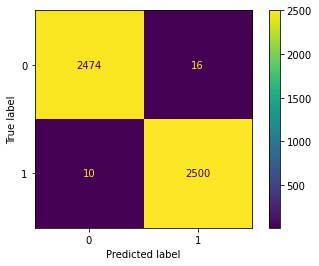

In [34]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 